In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch
import xgboost as xgb

# Artificial Neural Net

In [2]:
class ann1(nn.Module):
    # Implements a feed-forward neural net
    def __init__(self, hidden_nodes, batch_size = 32, seed = 12345):
        # SUPER INIT
        super().__init__()
        self.optimizer = None
        self.loss_fn = None
        # Set seed for reproducibility
        torch.manual_seed(seed)
        self.input_dim0, self.input_dim1 = (715950, 15)
        # Net layers
        self.layers = nn.Sequential(
            nn.Linear(self.input_dim1, hidden_nodes), 
            nn.PReLU(), 
            nn.Linear(hidden_nodes, 1), 
            nn.Sigmoid()
        )
        
    def forward(self, x): # Makes the forward pass in the net
        ''' 
        A method to make neural net predictions
        '''
        self.input_dim0, self.input_dim1 = x.shape
        if type(x) == np.ndarray:
            x = torch.tensor(x, dtype = torch.float32)
        outputs = self.layers(x)
        return outputs
    
    def train_net(self, val_x, val_y, num_epochs, filepath, loss_fn = nn.BCELoss(), learning_rate = .03, report_freq = 1, print_results = True, early_stopping_rounds = 5):
        ''' 
        A method to train the neural net on data
        '''
        self.loss_fn = loss_fn
        val_x = torch.tensor(val_x, dtype = torch.float32)
        val_y = torch.tensor(val_y, dtype = torch.float32)
        val_dataset = TensorDataset(val_x, val_y)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
        self.train()  # Set the model to training mode

        # Define optimizer, number of data points
        self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        dataset_size = self.input_dim0
        n_test = val_x.shape[0]
        # Make lists for later
        train_loss_list = []
        train_acc_list = []
        val_loss_list = []
        val_acc_list = []
        for epoch in range(self.epoch, self.epoch + num_epochs):
            for x_batch, y_batch in self.train_loader:
                # Forward pass 
                outputs = self.forward(x_batch)
                # Compute loss 
                loss = loss_fn(outputs, y_batch.unsqueeze(1))
                # Backpropagation 
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            threshold = .5 # Set probability threshold for classification 
            # Get epoch train results
            with torch.no_grad():
                outputs = self.forward(self.train_x)
                train_loss = loss_fn(outputs, self.train_y.unsqueeze(1))
                train_accuracy = torch.sum((outputs >= threshold) == self.train_y.unsqueeze(1))/dataset_size

            train_loss_list.append(train_loss.item())
            train_acc_list.append(train_accuracy.item())
            # Get epoch's validation set results
            with torch.no_grad():
                val_preds = self.forward(val_x)
                val_loss = loss_fn(val_preds, val_y.unsqueeze(1))
                val_accuracy = torch.sum((val_preds >= threshold) == val_y.unsqueeze(1))/n_test

            val_loss_list.append(val_loss.item())
            val_acc_list.append(val_accuracy.item())
            # Print epoch results?
            if print_results:
                if (epoch + 1) % report_freq == 0 or epoch == 0 or (epoch + 1) == num_epochs:
                    print(f"Epoch {epoch+1}/{self.epoch + num_epochs}, Train Loss: {train_loss.item():.4f}, Train Accuracy: {train_accuracy: .4f}, \
                    Val Loss: {val_loss.item(): .4f}, Val Accuracy: {val_accuracy: .4f}")
            # Save model if it is the best so far
            if epoch == 0 or min(val_loss_list) == val_loss:
                checkpoint = {
                    'model_state_dict': self.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'epoch': epoch,
                    'train_loss_list': train_loss_list,
                    'train_acc_list': train_acc_list,
                    'val_loss_list': val_loss_list,
                    'val_acc_list': val_acc_list
                }
                torch.save(checkpoint, filepath)
            # Add early stopping 
            elif val_loss_list.index(min(val_loss_list)) == epoch - early_stopping_rounds:
                break
        # Make epochs 
        self.epoch = self.epoch + num_epochs
        # Print best number of epochs 
        optimal_epochs = [ind + 1 for ind, val in enumerate(val_loss_list) if val == min(val_loss_list)][0]
        self.optimal_epochs = optimal_epochs
        if print_results:
            print(f"The optimal number of epochs was: {optimal_epochs}")
        self.load_best_model(filename = filepath)
    
    def evaluate(self, test_x, test_y, loss_fn = nn.BCELoss()):
        test_x = torch.tensor(test_x, dtype = torch.float32)
        test_y = torch.tensor(test_y, dtype = torch.float32)
        with torch.no_grad():
            test_preds = self.forward(test_x)
            test_accuracy = torch.sum((test_preds >= .5) == test_y.unsqueeze(1))/test_x.shape[0]
            test_sensitivity = torch.sum((test_preds >= .5) & (test_y.unsqueeze(1) == True))/(torch.sum((test_preds >= .5) & (test_y.unsqueeze(1) == True)) + torch.sum((test_preds >= .5) & (test_y.unsqueeze(1) == False)))
            test_specificity = torch.sum((test_preds <= .5) & (test_y.unsqueeze(1) == False))/(torch.sum((test_preds <= .5) & (test_y.unsqueeze(1) == False)) + torch.sum((test_preds <= .5) & (test_y.unsqueeze(1) == True)))
            test_loss = loss_fn(test_preds, test_y.unsqueeze(1))
        print(f"The test accuracy is:{test_accuracy: .4f}, test loss is:{test_loss: .4f}, test sensitivity is:{test_sensitivity: .4f}, test specificity is:{test_specificity: .4f}")
    
    def predict(self, new_x):
        '''
        Predict probabilities of a selected dataset
        '''
        new_x = torch.tensor(new_x, dtype = torch.float32)
        with torch.no_grad():
            preds = self.forward(new_x)
        return preds
    
    def load_best_model(self, filename):
        checkpoint = torch.load(filename)
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if k in model_dict}
        self.load_state_dict(pretrained_dict)
        if self.optimizer is None:
            self.optimizer = optim.Adam(self.parameters(), lr = .03)
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epoch = checkpoint['epoch']
        self.train_loss_list = checkpoint['train_loss_list']
        self.train_acc_list = checkpoint['train_acc_list']
        self.val_loss_list = checkpoint['val_loss_list']
        self.val_acc_list = checkpoint['val_acc_list']

In [3]:
# Read in preprocessed train and test data(plus several necessary alterations)
cols_to_imp = ['speed_std', 'dist_std', 'x_std', 'y_std'] # Columns to impute with mean
ais_test = pd.read_csv("/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/code/xgboost_preprocessed_data/xgboost_data_newtest2.csv")
ais_test[cols_to_imp] = ais_test[cols_to_imp].fillna(ais_test[cols_to_imp].mean())
x_test = ais_test.loc[:, ['speed_0', 'speed_med', 'speed_99', 'speed_std', 'dist_med', 'dist_99', 'dist_std', 'x_0', 
                          'x_med', 'x_99', 'x_std', 'y_0', 'y_med', 'y_99', 'y_std']].values
mmsi_test = ais_test.loc[:, 'mmsi'].values
trip_test = ais_test.loc[:, 'occ_num'].values

In [4]:
# Set up model
model3 = ann1(hidden_nodes = 20, seed = 2345)
model3.load_best_model("/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/code/models/ann0.pth")
# Get test results
test_preds = model3.predict(x_test) 
test_preds = pd.concat([pd.DataFrame(mmsi_test, columns = ["mmsi"]), 
                        pd.DataFrame(trip_test, columns = ["occ_num"]),
                        pd.DataFrame(test_preds, columns = ["prob_net"])], 
                        axis = 1)

# XGBoost

In [2]:
train_boost = xgb.Booster(model_file='/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/code/models/xgboost_new.json')

In [3]:
ais_test = pd.read_csv("/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/code/xgboost_preprocessed_data/xgboost_data_newtest2.csv")
mmsi_test = ais_test.loc[:, 'mmsi'].values
trip_test = ais_test.loc[:, 'occ_num'].values

In [4]:
test_mat = xgb.DMatrix(ais_test[['speed_0', 'speed_med', 'speed_99', 'speed_std', 'dist_med', 'dist_99', 
                                 'dist_std', 'x_0', 'x_med', 'x_99', 'x_std', 'y_0', 'y_med', 'y_99', 'y_std']])
test_preds = train_boost.predict(test_mat)
test_preds = pd.concat([pd.DataFrame(mmsi_test, columns = ["mmsi"]), 
                        pd.DataFrame(trip_test, columns = ["occ_num"]),
                        pd.DataFrame(test_preds, columns = ["prob_net"])], 
                        axis = 1)

# Format data

In [5]:
import glob
# Data formatting 
this_dir = "/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/retry2/east_asia"
files = glob.glob(this_dir + '/*.csv')
files.sort()
files = files[0:2]

# Set dtypes to avoid errors later
dtypes = {'FID': 'object', 'mmsi': 'int64', 'source_id': 'int64', 'imo': 'float64', 
          'vessel_name': 'object', 'callsign': 'object', 'vessel_type': 'object', 
          'vessel_type_code': 'float64', 'vessel_type_cargo': 'object', 'vessel_class': 'object',
          'length': 'float64', 'width': 'float64', 'flag_country': 'object', 'flag_code': 'float64',
          'destination': 'object', 'eta': 'int64', 'draught': 'float64', 'position': 'object',
          'latitude': 'float64', 'longitude': 'float64', 'sog': 'float64', 'cog': 'float64',
          'rot': 'float64', 'heading': 'int64', 'nav_status': 'object', 'nav_status_code': 'int64',
          'source': 'object', 'ts_pos_utc': 'int64', 'ts_static_utc': 'int64', 
          'dt_pos_utc': 'object', 'dt_static_utc': 'object', 'vessel_type_main': 'float64',
          'vessel_type_sub': 'float64', 'message_type': 'int64', 'eeid': 'float64', 'dtg': 'object'}

# Read each CSV file into a list of DataFrames
dfs = [pd.concat(pd.read_csv(file, dtype = dtypes, chunksize = 100000)) for file in files]

# Concatenate the DataFrames into a single DataFrame
ais = pd.concat(dfs, ignore_index=True).reset_index(drop = True)
# Get these for later
lat_min = ais.latitude.min()
lat_max = ais.latitude.max()
long_min = ais.longitude.min()
long_max = ais.longitude.max()

In [6]:
# Data formatting 
this_dir = "/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/retry2/east_asia"
files = glob.glob(this_dir + '/*.csv')
files.sort()
files = files[1000:1100]

# Set dtypes to avoid errors later
dtypes = {'FID': 'object', 'mmsi': 'int64', 'source_id': 'int64', 'imo': 'float64', 
          'vessel_name': 'object', 'callsign': 'object', 'vessel_type': 'object', 
          'vessel_type_code': 'float64', 'vessel_type_cargo': 'object', 'vessel_class': 'object',
          'length': 'float64', 'width': 'float64', 'flag_country': 'object', 'flag_code': 'float64',
          'destination': 'object', 'eta': 'int64', 'draught': 'float64', 'position': 'object',
          'latitude': 'float64', 'longitude': 'float64', 'sog': 'float64', 'cog': 'float64',
          'rot': 'float64', 'heading': 'int64', 'nav_status': 'object', 'nav_status_code': 'int64',
          'source': 'object', 'ts_pos_utc': 'int64', 'ts_static_utc': 'int64', 
          'dt_pos_utc': 'object', 'dt_static_utc': 'object', 'vessel_type_main': 'float64',
          'vessel_type_sub': 'float64', 'message_type': 'int64', 'eeid': 'float64', 'dtg': 'object'}

# Read each CSV file into a list of DataFrames
dfs = [pd.concat(pd.read_csv(file, dtype = dtypes, chunksize = 100000)) for file in files]

# Concatenate the DataFrames into a single DataFrame
ais = pd.concat(dfs, ignore_index=True).reset_index(drop = True)
ais['dtg'] = pd.to_datetime(ais['dtg'])
ais = ais.query("25 < latitude < 35 & 120 < longitude < 130")
ais = ais.sort_values(['mmsi', 'dtg'])

# Calculate the time difference between consecutive rows for each mmsi
ais['time_diff'] = ais.groupby('mmsi')['dtg'].diff()

# Create a new column called first_occurrence based on the identified conditions
ais['first_occurrence'] = ((ais['time_diff'].isnull()) | (ais['time_diff'] > pd.Timedelta(hours=4))).astype(int)
ais['occ_num'] = ais.groupby('mmsi').agg(occ_num = ('first_occurrence', 'cumsum')) # Separate different trips
ais = ais.loc[:, ['mmsi', 'occ_num', 'dtg', 'latitude', 'longitude']]
# Get these for later
lat_min2 = ais.latitude.min()
lat_max2 = ais.latitude.max()
long_min2 = ais.longitude.min()
long_max2 = ais.longitude.max()

In [7]:
import geopandas
import shapely
ais_map = pd.merge(ais, test_preds, on=['mmsi', 'occ_num'], how='inner')
#ais_map = ais_map[(ais_map['dtg'] >= pd.Timestamp('2023-09-02 10:00:00')) & (ais_map['dtg'] < pd.Timestamp('2023-09-23 10:00:00'))]
ais_map = geopandas.GeoDataFrame(ais_map, 
                                 geometry=geopandas.points_from_xy(ais_map.longitude, ais_map.latitude),
                                 crs='EPSG:4326')

In [8]:
# Make the grid
xmin = ais_map.longitude.min()
xmax = ais_map.longitude.max()
ymin = ais_map.latitude.min()
ymax = ais_map.latitude.max()

cell_size = 0.025 ## about 1.5-1.75 miles near equator

# Create grid cells
x_range = np.arange(np.floor(xmin), np.ceil(xmax), cell_size)
y_range = np.arange(np.floor(ymin), np.ceil(ymax), cell_size)

# projection of the grid
crs = "EPSG:4326"

# create the cells in a loop
grid_cells = []

# Create grid cell polygons
for x in x_range:
    for y in y_range:
        cell_polygon = shapely.geometry.box(x, y, x + cell_size, y + cell_size)
        grid_cells.append(cell_polygon)

# Create a GeoDataFrame from grid cell polygons
grid_df = geopandas.GeoDataFrame(geometry=grid_cells, crs=crs)

In [9]:
## now each point is associated with the box it belongs in 
if "grid_num" not in ais_map.columns:
    ais_map = geopandas.sjoin(ais_map, grid_df, how='left', predicate='intersects')
    ais_map.rename(columns={'index_right': 'grid_num'}, inplace=True)
ais_map.head(3)

,mmsi,occ_num,dtg,latitude,longitude,prob_net,geometry,grid_num
0,0,1,2023-10-12 17:10:26,29.5388,123.8436,1.0,POINT (123.84360 29.53880),61381
1,0,1,2023-10-12 17:20:46,28.6408,123.3665,1.0,POINT (123.36650 28.64080),53745
2,0,1,2023-10-12 17:25:51,28.6377,123.3663,1.0,POINT (123.36630 28.63770),53745


In [10]:
grid_probs = ais_map.groupby('grid_num')['prob_net'].mean()
grid_probs = pd.DataFrame(grid_probs).reset_index()

In [11]:
grid_probs2 = ais_map.drop_duplicates(subset=['mmsi', 'occ_num', 'grid_num']).groupby('grid_num')['prob_net'].mean()
grid_probs2 = pd.DataFrame(grid_probs2).reset_index()

In [12]:
if "geometry_y" not in ais_map.columns:
    ais_map = pd.merge(ais_map, grid_df[['geometry']], left_on='grid_num', right_index=True)
    ais_map = ais_map.rename(columns={'geometry_y': 'geometry'})
ais_map.head(3)

,mmsi,occ_num,dtg,latitude,longitude,prob_net,geometry_x,grid_num,geometry
0,0,1,2023-10-12 17:10:26,29.5388,123.8436,1.000000e+00,POINT (123.84360 29.53880),61381,"POLYGON ((123.85000 29.52500, 123.85000 29.550..."
3374881,352978264,1,2023-10-16 11:48:59,29.5384,123.8423,4.445438e-07,POINT (123.84230 29.53840),61381,"POLYGON ((123.85000 29.52500, 123.85000 29.550..."
4161522,412331052,1,2023-10-13 17:37:05,29.5350,123.8333,1.274805e-05,POINT (123.83330 29.53500),61381,"POLYGON ((123.85000 29.52500, 123.85000 29.550..."


In [13]:
if "prob_net_grid" not in ais_map.columns:
    ais_map = pd.merge(ais_map, grid_probs, on='grid_num').rename(columns={'prob_net_y': 'prob_net_grid'})
ais_map3 = pd.merge(ais_map, grid_probs2, on='grid_num').rename(columns={'prob_net_y': 'prob_net_grid'})
ais_map.head(3)

,mmsi,occ_num,dtg,latitude,longitude,prob_net_x,geometry_x,grid_num,geometry,prob_net_grid
0,0,1,2023-10-12 17:10:26,29.5388,123.8436,1.000000e+00,POINT (123.84360 29.53880),61381,"POLYGON ((123.85000 29.52500, 123.85000 29.550...",0.248204
1,352978264,1,2023-10-16 11:48:59,29.5384,123.8423,4.445438e-07,POINT (123.84230 29.53840),61381,"POLYGON ((123.85000 29.52500, 123.85000 29.550...",0.248204
2,412331052,1,2023-10-13 17:37:05,29.5350,123.8333,1.274805e-05,POINT (123.83330 29.53500),61381,"POLYGON ((123.85000 29.52500, 123.85000 29.550...",0.248204


In [14]:
ais_map2 = ais_map.drop_duplicates(subset=['grid_num'])
ais_map3 = ais_map3.drop_duplicates(subset=['grid_num'])

# Pic with model probabilities

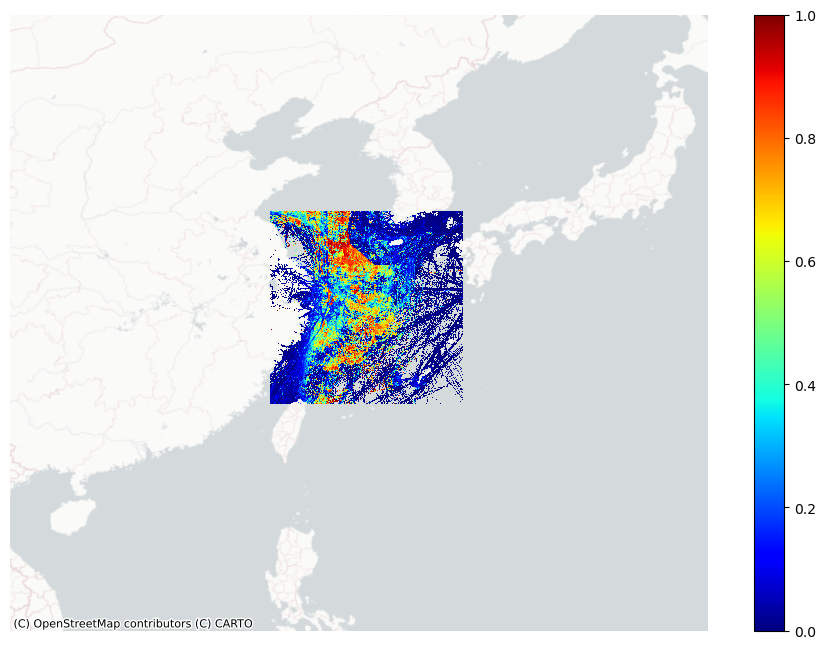

CPU times: user 15 s, sys: 488 ms, total: 15.5 s
Wall time: 17.1 s


In [15]:
%%time
import contextily as ctx
import matplotlib.pyplot as plt

# Convert ais_map to a GeoDataFrame
ais_map_gdf = geopandas.GeoDataFrame(ais_map2)

# Set the CRS for ais_map_gdf
ais_map_gdf.crs = "EPSG:4326"  # Assuming your data is in WGS84

# Plot the cells colored by the hot score
fig, ax = plt.subplots(figsize=(12, 8))
ais_map2.plot(ax=ax, column='prob_net_grid', cmap='jet', legend=True, aspect=1)

# Zoom out by setting the extent of the axes
ax.set_xlim(long_min - 1.5, long_max + 1.5)
ax.set_ylim(lat_min - 1.5, lat_max + 1.5)

# Add basemap
ctx.add_basemap(ax, crs=ais_map_gdf.crs, source=ctx.providers.CartoDB.PositronNoLabels)

# Hide axis
ax.axis('off')

# Show the plot
plt.show()

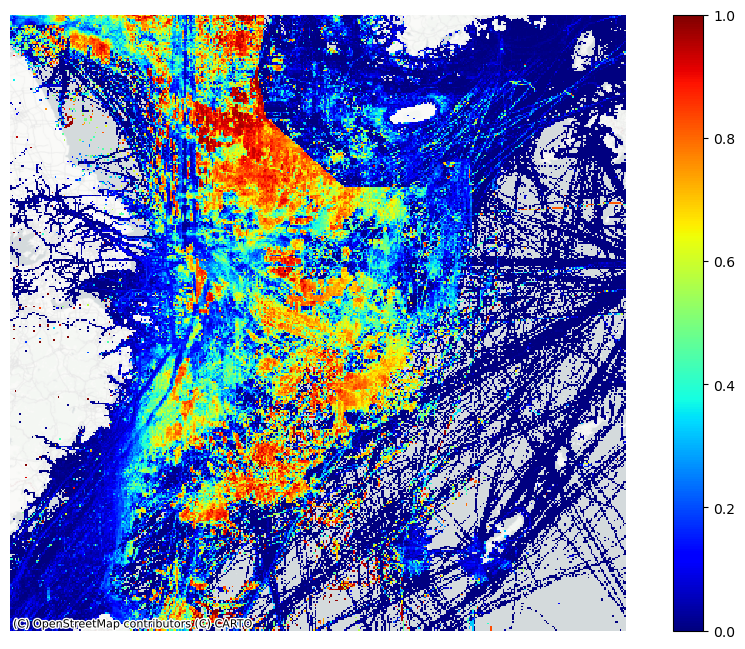

CPU times: user 16.6 s, sys: 406 ms, total: 17.1 s
Wall time: 17.4 s


In [16]:
%%time
import contextily as ctx
import matplotlib.pyplot as plt

# Convert ais_map to a GeoDataFrame
ais_map_gdf = geopandas.GeoDataFrame(ais_map2)

# Set the CRS for ais_map_gdf
ais_map_gdf.crs = "EPSG:4326"  # Assuming your data is in WGS84

# Plot the cells colored by the hot score
fig, ax = plt.subplots(figsize=(12, 8))
ais_map2.plot(ax=ax, column='prob_net_grid', cmap='jet', legend=True, aspect=1)

# Zoom out by setting the extent of the axes
ax.set_xlim(120, 130)
ax.set_ylim(25, 35)

# Add basemap
ctx.add_basemap(ax, crs=ais_map_gdf.crs, source=ctx.providers.CartoDB.PositronNoLabels)

# Hide axis
ax.axis('off')

# Show the plot
plt.show()

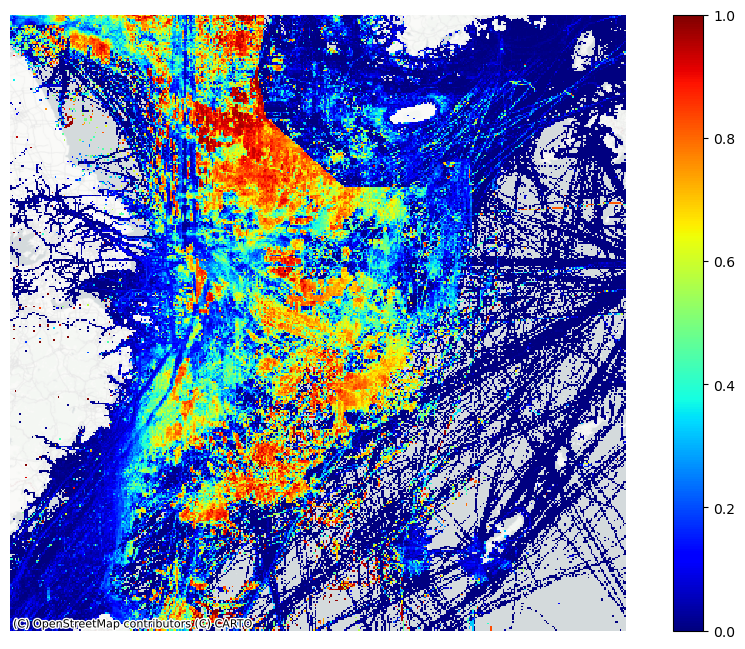

CPU times: user 14.6 s, sys: 350 ms, total: 15 s
Wall time: 15.2 s


In [17]:
%%time
import contextily as ctx
import matplotlib.pyplot as plt

# Convert ais_map to a GeoDataFrame
ais_map_gdf = geopandas.GeoDataFrame(ais_map3)

# Set the CRS for ais_map_gdf
ais_map_gdf.crs = "EPSG:4326"  # Assuming your data is in WGS84

# Plot the cells colored by the hot score
fig, ax = plt.subplots(figsize=(12, 8))
ais_map3.plot(ax=ax, column='prob_net_grid', cmap='jet', legend=True, aspect=1)

# Zoom out by setting the extent of the axes
ax.set_xlim(120, 130)
ax.set_ylim(25, 35)

# Add basemap
ctx.add_basemap(ax, crs=ais_map_gdf.crs, source=ctx.providers.CartoDB.PositronNoLabels)

# Hide axis
ax.axis('off')

# Show the plot
plt.show()

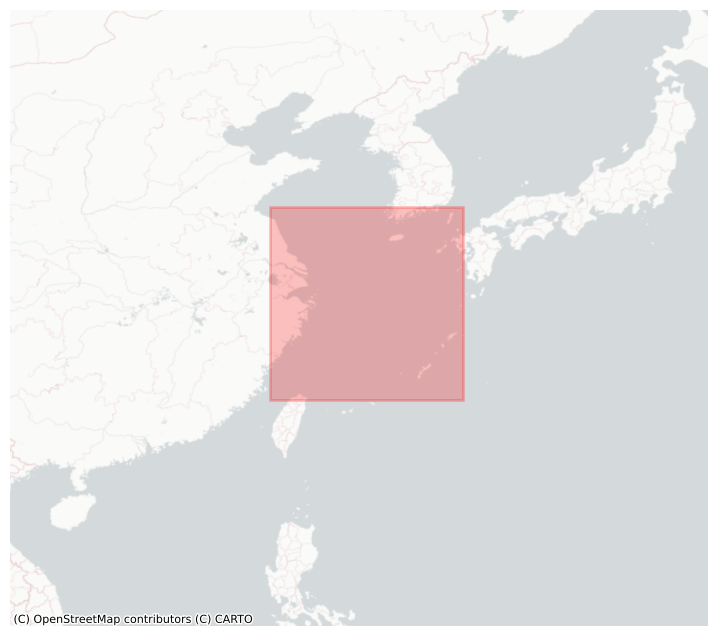

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))

# Zoom out by setting the extent of the axes
ax.set_xlim(long_min - 1.5, long_max + 1.5)
ax.set_ylim(lat_min - 1.5, lat_max + 1.5)

# Add basemap
ctx.add_basemap(ax, crs=ais_map_gdf.crs, source=ctx.providers.CartoDB.PositronNoLabels)

# Draw a red rectangle around the edge of the plot area
rect = plt.Rectangle((120, 25), 130 - 120, 35 - 25, linewidth=2, edgecolor='red', facecolor='red', alpha=0.23)
ax.add_patch(rect)

# Hide axis
ax.axis('off')

# Show the plot
plt.show()